#  Feature Crosses and Polynomial Features
    Explicitly Modeling Interactions and Nonlinear Effects

## Objective

This notebook provides a structured treatment of **feature crosses and polynomial transformations**, covering:

- Why linear models miss interactions
- Polynomial feature expansion
- Manual feature crosses driven by business logic
- Curse of dimensionality risks
- Interaction handling inside pipelines

It answers:

    When should we explicitly engineer interactions, and when should we let models learn them implicitly?


## Why Feature Crosses Matter

Many real-world relationships are **non-additive**.

Without interaction terms:
- Linear models underfit
- Important conditional effects are missed
- Business logic is lost

Tree-based models learn interactions implicitly — linear models do not.

## Imports and Dataset



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("../datasets/03_feature_engineering/customer_feature_encoding_benchmark.csv")
df.head()

,customer_id,age,income,avg_monthly_usage,support_tickets,satisfaction_level,region,customer_segment,churn
0,0,69,32133.0,81.606182,0,Low,North,segment_20,0
1,1,32,17875.0,28.316858,1,Medium,East,segment_12,0
2,2,78,26139.0,41.475782,1,High,East,segment_11,0
3,3,38,54872.0,82.361651,1,Low,East,segment_9,0
4,4,41,48679.0,57.360148,0,Very High,South,segment_10,0


In [20]:
df["tenure_years"] = (np.random.normal(9, 4, len(df)) + df.age / df.age.mean()).astype(int)

df.to_csv("../datasets/03_feature_engineering/customer_feature_encoding_benchmark.csv")

In [8]:
df.income.median()

np.float64(39386.0)

In [9]:
df['income'].fillna(df.income.median(), inplace=True)
df['avg_monthly_usage'].fillna(df.avg_monthly_usage.median(), inplace=True)

C:\Users\pantu\AppData\Local\Temp\ipykernel_19580\4052718768.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_monthly_usage'].fillna(df.avg_monthly_usage.median(), inplace=True)


## Step 1 – Separate Features and Target


In [10]:
target = "churn"

X = df.drop(columns=[target, "customer_id"])
y = df[target]


## Step 2 – Why Interactions Are Needed

Example:
- High income **and** high usage → lower churn
- High usage **alone** may increase churn

The effect depends on combinations.


## Step 3 – Polynomial Features

Polynomial expansion allows linear models to capture curvature.


In [11]:
from sklearn.preprocessing import PolynomialFeatures

numeric_features = [
    "age",
    "income",
    "tenure_years",
    "avg_monthly_usage"
]

poly = PolynomialFeatures(
    degree=2,
    include_bias=False
)

X_poly = poly.fit_transform(X[numeric_features])

poly_feature_names = poly.get_feature_names_out(numeric_features)

X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)
X_poly_df.head()


,age,income,tenure_years,avg_monthly_usage,age^2,age income,age tenure_years,age avg_monthly_usage,income^2,income tenure_years,income avg_monthly_usage,tenure_years^2,tenure_years avg_monthly_usage,avg_monthly_usage^2
0,69.0,32133.0,12.0,81.606182,4761.0,2217177.0,828.0,5630.826563,1.032530e+09,385596.0,2.622251e+06,144.0,979.274185,6659.568952
1,32.0,17875.0,8.0,28.316858,1024.0,572000.0,256.0,906.139451,3.195156e+08,143000.0,5.061638e+05,64.0,226.534863,801.844438
2,78.0,26139.0,13.0,41.475782,6084.0,2038842.0,1014.0,3235.110961,6.832473e+08,339807.0,1.084135e+06,169.0,539.185160,1720.240455
3,38.0,54872.0,5.0,82.361651,1444.0,2085136.0,190.0,3129.742751,3.010936e+09,274360.0,4.519349e+06,25.0,411.808257,6783.441611
4,41.0,48679.0,4.0,57.360148,1681.0,1995839.0,164.0,2351.766062,2.369645e+09,194716.0,2.792235e+06,16.0,229.440591,3290.186561


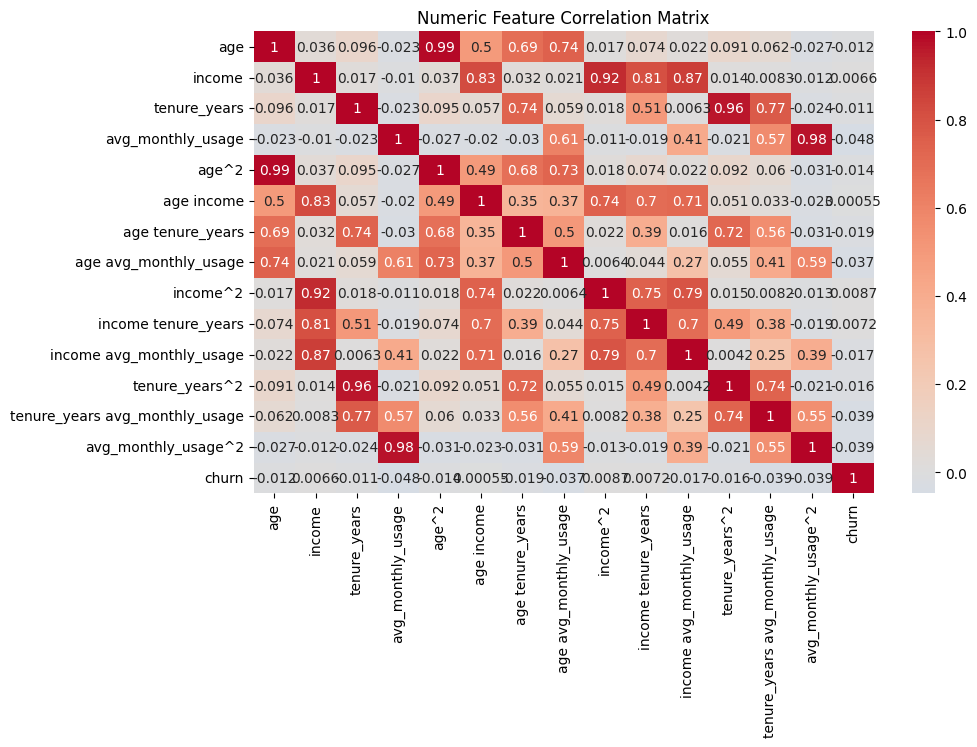

In [12]:
X_poly_df['churn'] = df['churn']

corr_x_poly = X_poly_df.corr()


plt.figure(figsize=(10, 6))
sns.heatmap(corr_x_poly, cmap="coolwarm", center=0, annot=True)
plt.title("Numeric Feature Correlation Matrix")
plt.show()

## Polynomial Risks

- Feature explosion
- Multicollinearity
- Overfitting

Polynomial features require:
- Scaling
- Regularization
- Feature selection



## Step 4 – Manual Feature Crosses (Business-Driven)

Manual crosses preserve interpretability.


In [13]:
df["income_usage_interaction"] = (
    df["income"] * df["avg_monthly_usage"]
)

df[["income", "avg_monthly_usage", "income_usage_interaction"]].head()


,income,avg_monthly_usage,income_usage_interaction
0,32133.0,81.606182,2.622251e+06
1,17875.0,28.316858,5.061638e+05
2,26139.0,41.475782,1.084135e+06
3,54872.0,82.361651,4.519349e+06
4,48679.0,57.360148,2.792235e+06


## Step 5 – Categorical × Numeric Interactions

    Interactions can be segment-specific.


In [14]:
segment_usage = (
    df.groupby("customer_segment")["avg_monthly_usage"]
    .transform("mean")
)

df["usage_relative_to_segment"] = (
    df["avg_monthly_usage"] / segment_usage
)

df[["customer_segment", "avg_monthly_usage", "usage_relative_to_segment"]].head()


,customer_segment,avg_monthly_usage,usage_relative_to_segment
0,segment_20,81.606182,1.490807
1,segment_12,28.316858,0.496418
2,segment_11,41.475782,0.774344
3,segment_9,82.361651,1.446934
4,segment_10,57.360148,1.018026


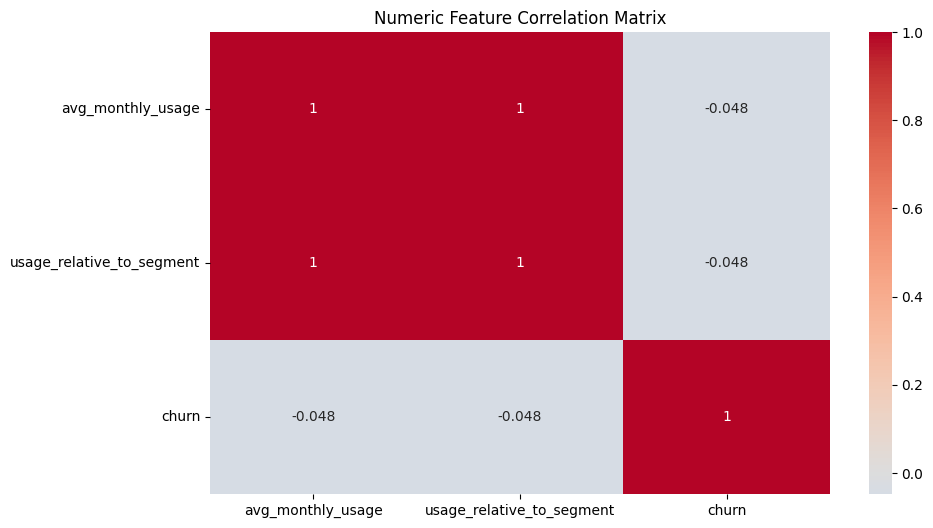

In [15]:
corr = df[[ "avg_monthly_usage", "usage_relative_to_segment", "churn"]].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True)
plt.title("Numeric Feature Correlation Matrix")
plt.show()

It requires:

- Feature selection


## Step 6 – Ordinal × Numeric Interactions

Ordinal variables can modulate numeric effects.


In [16]:
satisfaction_mapping = {
    "Very Low": 1,
    "Low": 2,
    "Medium": 3,
    "High": 4,
    "Very High": 5
}

df["satisfaction_encoded"] = df["satisfaction_level"].map(satisfaction_mapping)

df["tenure_satisfaction_interaction"] = (
    df["tenure_years"] * df["satisfaction_encoded"]
)

df["tenure_satisfaction_interaction"]

0       24
1       24
2       52
3       10
4       20
        ..
4995    16
4996    39
4997    70
4998    20
4999    27
Name: tenure_satisfaction_interaction, Length: 5000, dtype: int64

## Step 7 – Interactions via One-Hot Encoding

OHE × numeric interactions increase dimensionality rapidly.


In [17]:
df_ohe = pd.get_dummies(
    df,
    columns=["region"],
    drop_first=True
)

for col in df_ohe.filter(like="region_").columns:
    df_ohe[f"{col}_usage"] = df_ohe[col] * df_ohe["avg_monthly_usage"]

df_ohe

,customer_id,age,income,avg_monthly_usage,support_tickets,satisfaction_level,customer_segment,churn,tenure_years,income_usage_interaction,usage_relative_to_segment,satisfaction_encoded,tenure_satisfaction_interaction,region_North,region_South,region_West,region_North_usage,region_South_usage,region_West_usage
0,0,69,32133.0,81.606182,0,Low,segment_20,0,12,2.622251e+06,1.490807,2,24,True,False,False,81.606182,0.000000,0.00000
1,1,32,17875.0,28.316858,1,Medium,segment_12,0,8,5.061638e+05,0.496418,3,24,False,False,False,0.000000,0.000000,0.00000
2,2,78,26139.0,41.475782,1,High,segment_11,0,13,1.084135e+06,0.774344,4,52,False,False,False,0.000000,0.000000,0.00000
3,3,38,54872.0,82.361651,1,Low,segment_9,0,5,4.519349e+06,1.446934,2,10,False,False,False,0.000000,0.000000,0.00000
4,4,41,48679.0,57.360148,0,Very High,segment_10,0,4,2.792235e+06,1.018026,5,20,False,True,False,0.000000,57.360148,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,37,12987.0,31.372110,2,Low,segment_16,1,8,4.074296e+05,0.557234,2,16,False,False,True,0.000000,0.000000,31.37211
4996,4996,81,15652.0,73.386246,1,Medium,segment_21,0,13,1.148642e+06,1.322402,3,39,False,False,False,0.000000,0.000000,0.00000
4997,4997,33,27388.0,69.802161,1,Very High,segment_15,0,14,1.911742e+06,1.248056,5,70,False,True,False,0.000000,69.802161,0.00000
4998,4998,68,45446.0,67.571184,0,Low,segment_13,0,10,3.070840e+06,1.261161,2,20,False,False,False,0.000000,0.000000,0.00000


## Step 8 – Interaction Handling by Model Type

| Model | Needs Crosses |
|------|---------------|
| Linear / Logistic | Yes |
| Tree-Based | No |
| Boosting | Rarely |
| Neural Networks | Implicit |


## Step 9 – Interactions Inside Pipelines


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LogisticRegression(max_iter=1000))
])


## Common Mistakes (Avoided)

- `[neg] -` Blind polynomial expansion
- `[neg] -` Crossing identifiers
- `[neg] -` Ignoring cardinality
- `[neg] -` No regularization
- `[neg] -` Creating interactions before splitting


## Summary Table

| Technique | Use Case |
|---------|----------|
| PolynomialFeatures | Nonlinear numeric effects |
| Manual crosses | Business logic |
| Ordinal × Numeric | Ranked modulation |
| OHE × Numeric | Segment effects |


## Key Takeaways

- Interactions expose hidden structure
- Manual crosses preserve interpretability
- Polynomial features require control
- Tree models reduce need for crosses
- Pipelines prevent leakage


## Next Notebook

03_Feature_Engineering/

└── [07_temporal_and_lag_features.ipynb](07_temporal_and_lag_features.ipynb)


<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)